In [1]:
from fastai.vision.all import *
from self_supervised.layers import *

In [2]:
datapath = Path("plant-pathology-2021-fgvc8/")

In [3]:
datapath.ls()

(#5) [Path('plant-pathology-2021-fgvc8/train.csv'),Path('plant-pathology-2021-fgvc8/test_images'),Path('plant-pathology-2021-fgvc8/train_images_512'),Path('plant-pathology-2021-fgvc8/train_images'),Path('plant-pathology-2021-fgvc8/sample_submission.csv')]

In [4]:
train_df = pd.read_csv(datapath/'train.csv')

In [5]:
label_dist = train_df['labels'].value_counts()

In [6]:
label_dist

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
cider_apple_rust                   1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

In [7]:
train_df['num_disease'] = train_df['labels'].apply(lambda o: len(o.split()))

In [8]:
train_df.query("num_disease == 1")['labels'].value_counts()

scab                  4826
healthy               4624
frog_eye_leaf_spot    3181
cider_apple_rust      1860
complex               1602
powdery_mildew        1184
Name: labels, dtype: int64

In [9]:
train_df.query("num_disease > 1")['labels'].value_counts()

scab frog_eye_leaf_spot            686
scab frog_eye_leaf_spot complex    200
frog_eye_leaf_spot complex         165
rust frog_eye_leaf_spot            120
rust complex                        97
powdery_mildew complex              87
Name: labels, dtype: int64

In [10]:
# def read_img(im): return PILImage.create(datapath/f'train_images/{im}')

# img = read_img(train_df['image'][0])

# img.shape

# def resize_img(img, sz=512):
#     targ_sz = resize_to(img, use_min=True, targ_sz=sz)
#     return img.resize(targ_sz, resample=Image.BILINEAR).convert("RGB")

# resizepath = datapath/'train_images_512'

# resizepath.mkdir()

# fns = train_df['image'].values; fns[:5]

# def read_resize_save(fn):
#     img = read_img(fn)
#     img = resize_img(img)
#     img.save(resizepath/f'{fn}')

# # parallel(read_resize_save, fns, progress=True)

### Data

In [11]:
files = train_df['image'].values
fn2label = dict(zip(train_df['image'], train_df['labels'].apply(lambda o: o.split())))

In [12]:
def read_img(im): return PILImage.create(datapath/f'train_images_512/{im}')
def read_label(fn): return fn2label[fn]

In [13]:
def get_dls(files, bs=32, size=448):

    tfms = [[read_img, ToTensor, RandomResizedCrop(size, min_scale=.7)], 
            [read_label, MultiCategorize(), OneHotEncode]]

    dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1, seed=0.2)(files))

    batch_augs = aug_transforms()

    batch_tfms = [IntToFloatTensor] + batch_augs
    dls = dsets.dataloaders(bs=bs, after_batch=batch_tfms)
    return dls

In [1]:
import wandb
from fastai.callback.wandb import WandbCallback

In [14]:
# dls.show_batch()

In [15]:
# tf_efficientnet_b4_ns - lr 2e-2, size 448, bs 32
# resnet101d - lr 2e-2, size 448, bs 32
# vit_base_patch16_384 - lr 1e-3 size 384, bs 32 (checkpoint 2)
# vit_base_resnet50_384 - lr 1e-3 size 384 bs 24 (checkpoint 12)

In [16]:
# #export 
# from torch.utils.checkpoint import checkpoint_sequential
    
# class CheckpointVisionTransformer(Module):
#     def __init__(self, vit_model, checkpoint_nchunks=2):
#         self.checkpoint_nchunks = checkpoint_nchunks
#         self.vit_model = vit_model
    
#     def forward_features(self, x):
#         B = x.shape[0]
#         x = self.vit_model.patch_embed(x)

#         cls_tokens = self.vit_model.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
#         x = torch.cat((cls_tokens, x), dim=1)
#         x = x + self.vit_model.pos_embed
#         x = self.vit_model.pos_drop(x)
#         x = checkpoint_sequential(self.vit_model.blocks, self.checkpoint_nchunks, x)
#         x = self.vit_model.norm(x)[:, 0]
#         x = self.vit_model.pre_logits(x)
#         return x

#     def forward(self, x):
#         x = self.forward_features(x)
#         x = self.vit_model.head(x)
#         return x

In [17]:
@patch
def name(self:F1ScoreMulti): return "f1_multi_macro"
f1macro = F1ScoreMulti(average='macro')
@patch
def name(self:F1ScoreMulti): return "f1_multi_micro"
f1micro = F1ScoreMulti(average='micro')

In [18]:
arch = "vit_base_resnet50_384"
bs, size, lr, epochs = 24, 384, 2e-2, 30
dls = get_dls(files[:5000],bs,size)

In [21]:
WANDB = False

In [ ]:
if WANDB:
    xtra_config = {"Arch":arch, "Size":size, "lr": lr}
    wandb.init(project="plant-pathology-2021", config=xtra_config)

In [19]:
encoder = create_encoder(arch, pretrained=False, n_in=3)
if arch == 'vit_base_patch16_384':  encoder = CheckpointVisionTransformer(encoder, 2)
if arch == 'vit_base_resnet50_384': encoder = CheckpointVisionTransformer(encoder, 12)
# if arch == 'tf_efficientnet_b4_ns': encoder = CheckpointEfficientNet(encoder, 2)
with torch.no_grad(): nf = encoder(torch.randn(2,3,size,size)).size(-1)
classifier = create_cls_module(nf, dls.c)
model = nn.Sequential(encoder, classifier)
cbs = [SaveModelCallback(every_epoch=True, fname=f"{arch}_size{size}_lr{lr}_epochs{epochs}")]
if WANDB: cbs += [WandbCallback(log_preds=False,log_model=False)]
learn = Learner(dls, model, opt_func=ranger, cbs=cbs
                metrics=[f1macro, f1micro], loss_func=BCEWithLogitsLossFlat())
learn.to_fp16();

/opt/conda/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [ ]:
learn.fit_flat_cos()

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.3019951581954956)

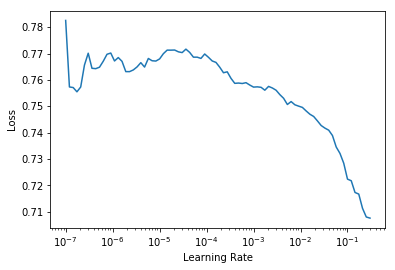

In [20]:
learn.lr_find()

In [ ]:
if WANDB: wandb.finish()